In [1]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn import metrics
import datetime
from finta import TA

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [2]:
def to_sequences(seq_size, obs, target_col):
    x = []
    y = []

    for i in range(len(obs)-seq_size):
        window = obs.iloc[i:(i+seq_size), target_col:].values
        after_window = obs.iloc[i+seq_size, target_col]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    x_train = np.array(x)
    y_train = np.array(y)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[3]))
    
    return x_train, y_train

In [3]:
def prep_data(df,target_col):
    df_train = df.iloc[:6000, :]
    df_test = df.iloc[6000:, :]

    x_train = df_train.drop(target_col, axis=1)
    y_train = df_train[target_col]

    x_test = df_test.drop(target_col, axis=1)
    y_test = df_test[target_col]

    y_train = y_train.to_numpy().reshape((-1,1))
    y_test = y_test.to_numpy().reshape((-1,1))

    x_train, y_train = to_sequences(50, df_train, 0)
    x_test, y_test = to_sequences(50, df_test, 0)

    print(x_train.shape)

    input_shape = x_train.shape[1:]
    start = datetime.datetime.now()
    model = build_model(
        input_shape,
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=4,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4)
    )

    model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=10, \
        restore_best_weights=True)]

    model.fit(
        x_train,
        y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
    )
    finish = datetime.datetime.now()
    print("time to execute = ",finish-start)

    return model, x_test, y_test

In [4]:
CAPITAL = 3.27
# Get the baseline capital
def backtest(pred, y_test, df, periods_per_day, target_col):
    total   = 0
    pnls    = []
    counter = 0

    df = df.set_index('Date').copy()

    idx = list(df[target_col].index)
    idx_n = []

    for x in range(len(pred)):
        if pred[x][0] > 0.0:
            total += y_test[x]
        elif pred[x][0] < 0.0:
            total -= y_test[x]
        if (counter % periods_per_day == 0):
            pnls.append(total)
            idx_n.append(idx[counter])
        counter += 1

    rets = pd.DataFrame(data=pnls, columns=['cum_pnl'], index=idx_n)
    rets['portfolio'] = rets['cum_pnl'] + CAPITAL 
    rets['pct_pnl'] = rets['portfolio'].pct_change()
    rets = rets.dropna()

    return rets

In [5]:
import matplotlib.pyplot as plt

def perf_summ(
    data: pd.DataFrame, adj: int = 12, title="Metric"
) -> pd.DataFrame:
    summary = pd.DataFrame(
        data=data.mean() * adj, index=[title], columns=["Annualized Return"]
    )
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        (data[data < 0]).std() * np.sqrt(adj)
    )

    summary["Skewness"] = data.skew()
    summary["Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()
    summary["Calmar Ratio"] = data.mean()/drawdowns.min()

    return summary.T

Original data

In [10]:
periods_per_day = 10
fn = "qm_data_tufv.csv"
df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=False)

target_col = 'fut'
df['Date'] = pd.to_datetime(df['Date'])
df['CosHour'] = np.cos(2*np.pi*df['Date'].dt.hour/24)
df['SinHour'] = np.sin(2*np.pi*df['Date'].dt.hour/24)
col = df.pop(target_col)
df.insert(0, col.name, col)
df_f = df.drop(['Sum', 'Date'], axis=1).dropna()

model_o, x_test_o, y_test_o = prep_data(df_f,target_col)

(5950, 50, 21)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 21)]     0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 50, 21)      42          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 50, 21)      89109       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                             

In [11]:
model_o.evaluate(x_test_o, y_test_o, verbose=1)
pred = model_o.predict(x_test_o)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_o))
print("Score (RMSE): {}".format(score))

59/59 [==============================] - 0s 4ms/step
Score (RMSE): 0.023596942768496502


In [12]:
rets = backtest(pred, y_test_o, df, periods_per_day, target_col)

,Window=50
Annualized Return,0.345684
Annualized Volatility,0.392212
Annualized Sharpe Ratio,0.881370
Annualized Sortino Ratio,1.440119
Skewness,-0.042521
Kurtosis,0.486226
VaR (0.05),-0.040461
CVaR (0.05),-0.049964
Min,-0.082624
Max,0.069417


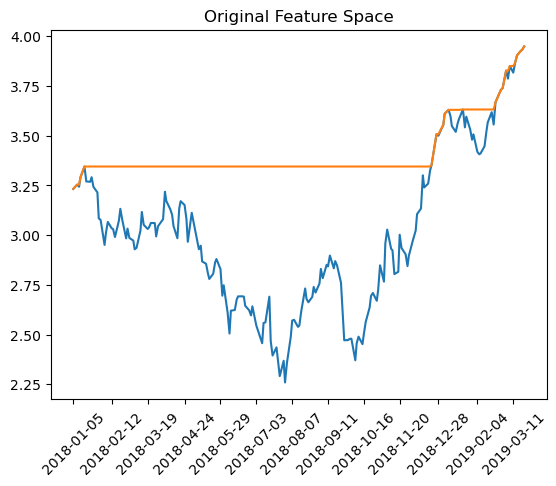

In [13]:
display(perf_summ(rets['pct_pnl'], adj=252, title="Window=50"))

plt.plot(rets['portfolio'])
plt.plot(rets['portfolio'].cummax())
plt.title('Original Feature Space')
plt.xticks(ticks=rets.index[::15], rotation=45)
plt.show()

PCA Decomposition

In [18]:
from sklearn.decomposition import PCA 
import seaborn as sns

fn = "qm_data_tufv.csv"
df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=0)

X = df.drop(columns=['fut','Sum'])
X = X.dropna()

<AxesSubplot: >

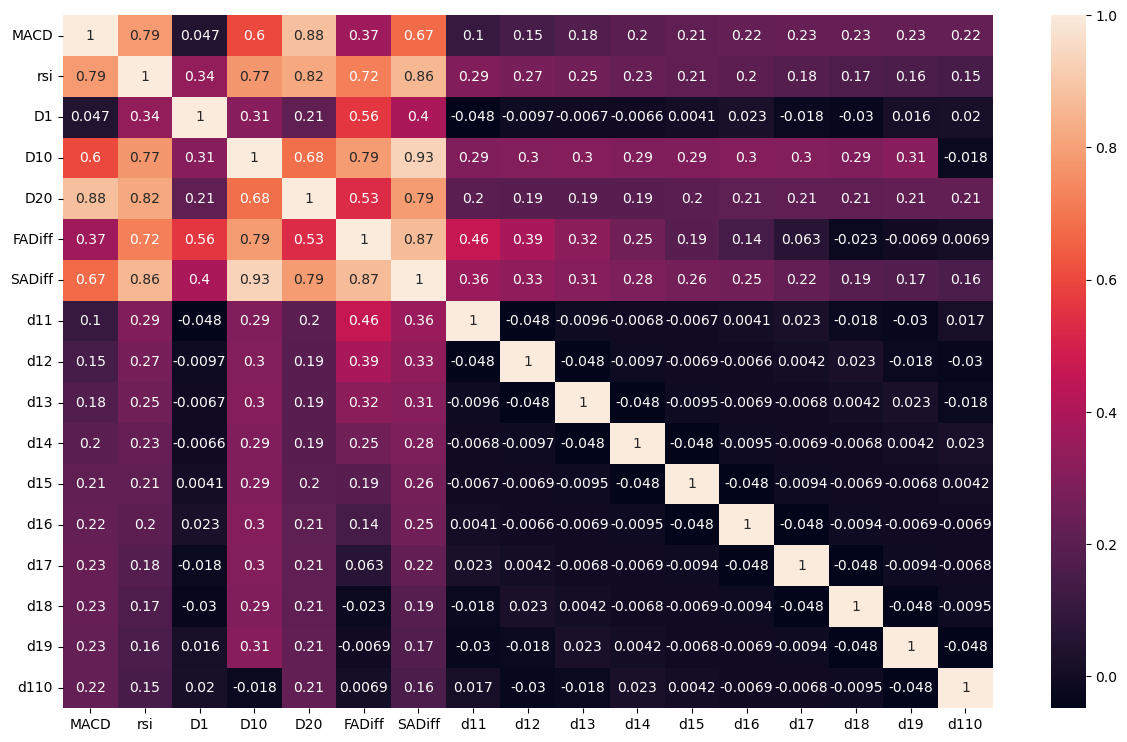

In [21]:
plt.figure(figsize=(15,9))
sns.heatmap(X.drop(columns=['time']).corr(), annot=True)

assuming the scales of all the features can be compared like this

- a high feature space can be prone to overfitting, so let's perform PCA to reduce dimensionality

In [34]:
from sklearn.decomposition import PCA 

fn = "qm_data_tufv.csv"
df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=0)

X = df.drop(columns=['fut','Sum'])
X = X.dropna()

pca = PCA(n_components=2)  # We will choose 2 principal components
X = X.dropna()
comps = pca.fit_transform(X)

transformed_data = pd.DataFrame(comps,index=df.index)
transformed_data = pd.concat([df['fut'],transformed_data],axis=1)
transformed_data = transformed_data.dropna().reset_index()

# A copy of a version of  transformed data is also present in the files (new_features1.csv)

In [35]:
periods_per_day = 10
#fn = "new_features1.csv"
#df = pd.read_csv(fn, sep=',', na_values=['-1'], index_col=False)

df = transformed_data 
target_col = 'fut'
df['Date'] = pd.to_datetime(df['Date'])
df['CosHour'] = np.cos(2*np.pi*df['Date'].dt.hour/24)
df['SinHour'] = np.sin(2*np.pi*df['Date'].dt.hour/24)
col = df.pop(target_col)
df.insert(0, col.name, col)
df_f = df.dropna().drop(columns=['Date'])

model_pca, x_test_pca, y_test_pca = prep_data(df_f,target_col)

(5950, 50, 5)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 layer_normalization_40 (LayerN  (None, 50, 5)       10          ['input_6[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_20 (Multi  (None, 50, 5)       23557       ['layer_normalization_40[0][0]', 
 HeadAttention)                                                   'layer_normalization_40[0][0]'] 
                                                                              

In [36]:
model_pca.evaluate(x_test_pca, y_test_pca, verbose=1)
pred = model_pca.predict(x_test_pca)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_pca))
print("Score (RMSE): {}".format(score))

59/59 [==============================] - 0s 4ms/step
Score (RMSE): 0.08584452322545767


,Window=50
Annualized Return,0.215829
Annualized Volatility,0.320381
Annualized Sharpe Ratio,0.673663
Annualized Sortino Ratio,1.189719
Skewness,0.183399
Kurtosis,0.489380
VaR (0.05),-0.030228
CVaR (0.05),-0.038397
Min,-0.069446
Max,0.059039


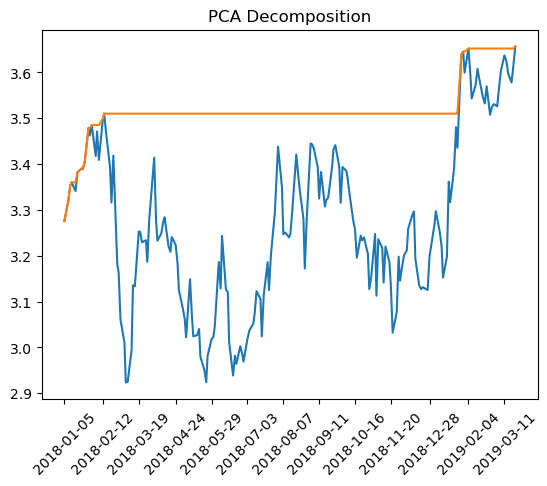

In [37]:
rets = backtest(pred, y_test_pca, df, periods_per_day, target_col)

display(perf_summ(rets['pct_pnl'], adj=252, title="Window=50"))

plt.plot(rets['portfolio'])
plt.plot(rets['portfolio'].cummax())
plt.xticks(ticks=rets.index[::15], rotation=45)
plt.title('PCA Decomposition')
plt.show()